In [1]:
import numpy as np
import pandas as pd
import textblob

import seaborn
from matplotlib import pyplot

import string
from textblob import TextBlob, Word
import re
import nltk
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn import metrics

from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yasmi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**DATA CLEANING**

In [2]:
nlp_df= pd.read_csv("train.csv")
nlp_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
nlp_df[nlp_df['target']== 0]

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0
7587,10841,NaN,NaN,Sirens everywhere!,0


In [4]:
#check shape
nlp_df.shape

(7613, 5)

In [5]:
#checknans
locnull= nlp_df['location'].isnull().values.sum()
keywordnull= nlp_df['keyword'].isnull().values.sum()
print (locnull)
print (keywordnull)

2533
61


In [6]:
nlp_df= nlp_df.drop(columns= 'location')

In [7]:
#make lowercase
nlp_df['text']= nlp_df['text'].apply(str.lower)

In [8]:
#function to remove punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [9]:
#remove punctuation for easier parsing
nlp_df['text']= nlp_df['text'].apply(remove_punctuations)

In [10]:
#helper function to remove url
def remove_url (text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    return (text)


In [11]:
#remove urls for better tokenization
nlp_df['text']= nlp_df['text'].apply(remove_url)

In [12]:
#helper function to lemmatize
def lem(text):
    
    list_empty=[]
    
    for i in text.split():
        w = Word(i)
        
        list_empty.append(w.lemmatize())
    #convert list to string
    string = " ".join(list_empty)
    
    return string

In [13]:
#apply lemmatization
nlp_df['text']= nlp_df['text'].apply(lem)
nlp_df

,id,keyword,text,target
0,1,NaN,our deed are the reason of this earthquake may...,1
1,4,NaN,forest fire near la ronge sask canada,1
2,5,NaN,all resident asked to shelter in place are bei...,1
3,6,NaN,13000 people receive wildfire evacuation order...,1
4,7,NaN,just got sent this photo from ruby alaska a sm...,1
...,...,...,...,...
7608,10869,NaN,two giant crane holding a bridge collapse into...,1
7609,10870,NaN,ariaahrary thetawniest the out of control wild...,1
7610,10871,NaN,m194 0104 utc5km s of volcano hawaii httptcozd...,1
7611,10872,NaN,police investigating after an ebike collided w...,1


**Weighting and rudimentary analysis:**

In [14]:
count_vectorizer = CountVectorizer()
word_counts= count_vectorizer.fit_transform(nlp_df["text"])

In [15]:
count_vectorizer.inverse_transform(word_counts[0])

[array(['our', 'deed', 'are', 'the', 'reason', 'of', 'this', 'earthquake',
        'may', 'allah', 'forgive', 'all'], dtype='<U52')]

In [16]:
print(np.shape(word_counts))
print(word_counts.nnz)

(7613, 21105)
101668


In [17]:
total_tokens = word_counts.sum()
word_totals = word_counts.sum(axis=0)
word_totals = np.ravel(word_totals)
print(word_totals.shape)
vocabulary = count_vectorizer.get_feature_names_out()
print("words that occur less than five times: ", len(vocabulary[np.where(word_totals < 5)]))

(21105,)
words that occur less than five times:  18415


total count:  10439
[(3266, 'the'), (1979, 'in'), (1946, 'to'), (1828, 'of'), (1420, 'and')]


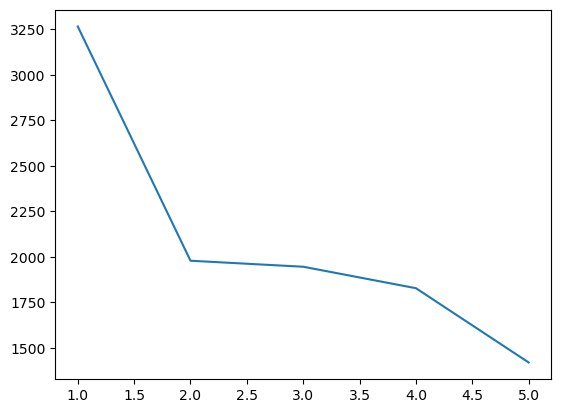

<AxesSubplot:>

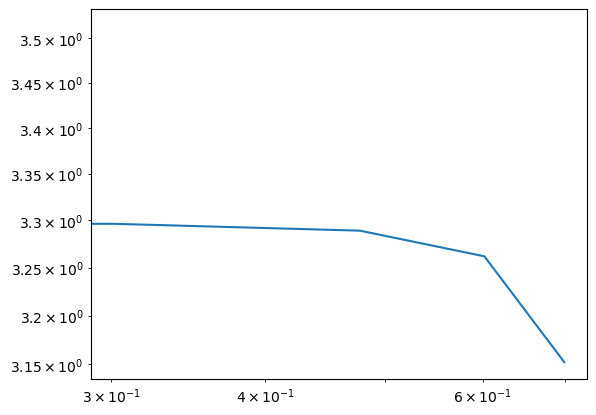

In [18]:
most_frequent_words = vocabulary[np.where(word_totals > 1000)]
most_frequent_word_counts = word_totals[np.where(word_totals > 1000)]

print("total count: ", most_frequent_word_counts.sum())
print(sorted(zip(most_frequent_word_counts, most_frequent_words), reverse=True))

seaborn.lineplot(x=range(len(most_frequent_words), 0, -1),
                 y=np.sort(most_frequent_word_counts))
pyplot.show()
pyplot.xscale('log')
pyplot.yscale('log')
seaborn.lineplot(x=range(len(most_frequent_words), 0, -1),
                 y=np.sort(most_frequent_word_counts))

In [19]:
tfidf_vectorizer= TfidfVectorizer(min_df= 5)
reviews_tfidf= tfidf_vectorizer.fit_transform(nlp_df["text"]).toarray()